# Assignment 8

Develop a model for 20 news groups dataset from scikit-learn. Select 20% of data for test set.  

Develop metric learning model with siamese network [3 points] and triplet loss [3 points] (from seminar). 
Use KNN and LSH (any library for approximate nearest neighbor search) for final prediction after the network was trained. [2 points]

! Remember, that LSH gives you a set of neighbor candidates, for which you have to calculate distances to choose top-k nearest neighbors. 

Your quality metric = accuracy score [2 points if acc > 0.8 ]

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = fetch_20newsgroups('data/', subset='all')

In [3]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
print(data['data'][10])

From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: 14 Apr 93   God's Promise in 1 John 1: 7
Organization: Cookamunga Tourist Bureau
Lines: 17

In article <1qknu0INNbhv@shelley.u.washington.edu>, > Christian:  washed in
the blood of the lamb.
> Mithraist:  washed in the blood of the bull.
> 
> If anyone in .netland is in the process of devising a new religion,
> do not use the lamb or the bull, because they have already been
> reserved.  Please choose another animal, preferably one not
> on the Endangered Species List.  

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent
---
sandvik@newton.apple.com. ALink: KSAND -- Private activities on the net.



In [0]:
X, y = data['data'], data['target']

In [0]:
df = pd.DataFrame({'text': X, 'label': y})

In [0]:
df

,text,label
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4
...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1


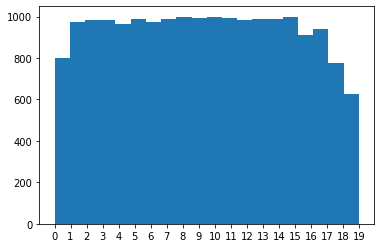

In [0]:
plt.hist(y, bins=20)
plt.xticks(range(20));

Лейблы распределены примерно равномерно

## Подготовим данные

In [0]:
import re

In [0]:
df['clean_text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
df['clean_text'] = df['clean_text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
df['clean_text'] = df['clean_text'].str.lower()
df['clean_text'] = df['clean_text'].str.replace("[0-9]", " ")
df['clean_text'] = df['clean_text'].apply(lambda x:' '.join(x.split()))

In [0]:
words_to_remove = ['from', 'subject', 'organization', 'lines', 'nntp-posting-gost']

df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(ch for ch in x.split() if ch not in words_to_remove))

In [0]:
import spacy

In [0]:
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [0]:
df['clean_text'] = lemmatization(df['clean_text'])

In [0]:
print(df.text[10])

From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: 14 Apr 93   God's Promise in 1 John 1: 7
Organization: Cookamunga Tourist Bureau
Lines: 17

In article <1qknu0INNbhv@shelley.u.washington.edu>, > Christian:  washed in
the blood of the lamb.
> Mithraist:  washed in the blood of the bull.
> 
> If anyone in .netland is in the process of devising a new religion,
> do not use the lamb or the bull, because they have already been
> reserved.  Please choose another animal, preferably one not
> on the Endangered Species List.  

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent
---
sandvik@newton.apple.com. ALink: KSAND -- Private activities on the net.



In [0]:
print(df.clean_text[10])

sandviknewton.apple.com kent sandvik re apr god 's promise in john cookamunga tourist bureau in article qknu innbhvshelley.u.washington.edu , christian wash in the blood of the lamb . mithraist wash in the blood of the bull . if anyone in .netland be in the process of devise a new religion , do not use the lamb or the bull , because -PRON- have already be reserve . please choose another animal , preferably one not on the endanger species list . this will be a hard task , because most culture use most animal for blood sacrifice . -PRON- have to be something relate to -PRON- current postmodernism state . hmm , what about use computer cheer , kent sandviknewton.apple.com . alink ksand private activity on the net .


In [0]:
!pip install sentence-transformers

In [0]:
from sentence_transformers import SentenceTransformer

In [0]:
model = SentenceTransformer('bert-base-nli-max-tokens')

100%|██████████| 405M/405M [00:25<00:00, 16.1MB/s]


In [0]:
X_encoded = model.encode(df['clean_text'])

In [0]:
df['encoded'] = torch.tensor(X_encoded)

In [0]:
df.to_csv("data.csv")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp data.csv drive/My\ Drive/assignment_8/

In [0]:
!cp drive/My\ Drive/assignment_8/data.csv data/

In [0]:
df = pd.read_csv('data/data.csv', index_col=0, converters={"encoded": lambda x: eval(x, {'tensor': torch.tensor})})

In [0]:
train, test = train_test_split(df, test_size=0.2)
train, valid = train_test_split(train, test_size=0.1)

In [235]:
train.head()

,text,label,clean_text,encoded
5803,From: kolstad@cae.wisc.edu (Joel Kolstad)\nSub...,12,kolstadcae.wisc.edu joel kolstad re dumb quest...,"(tensor(1.1970), tensor(1.6187), tensor(1.7144..."
10284,From: ejajko@hertz.elee.calpoly.edu (Edward Ja...,12,ejajkohertz.elee.calpoly.edu edward jajko re h...,"(tensor(0.6720), tensor(1.2550), tensor(1.4880..."
14020,From: huot@cray.com (Tom Huot)\nSubject: Re: U...,10,huotcray.com tom huot re ulf and all ... nntpp...,"(tensor(0.4812), tensor(1.2513), tensor(1.5760..."
17607,From: thinman@netcom.com (Technically Sweet)\n...,1,thinmannetcom.com technically sweet what be re...,"(tensor(0.6507), tensor(0.9735), tensor(1.3894..."
5132,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0,mathew mathewmantis.co.uk re political atheist...,"(tensor(0.6182), tensor(1.8986), tensor(1.2612..."


## Создание модели и обучение

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SiameseNet(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.criterion = criterion
        self.fc = nn.Linear(768, 64).to(device)
        # self.avgpool = nn.AdaptiveAvgPool1d(output_size=256)
        # self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=7, stride=2)

    def branch(self, x):
        return self.fc(x)

    def forward(self, batch):
        (anchor, positive, negative) = batch
        negative = self.branch(negative.to(device))
        anchor = self.branch(anchor.to(device))
        positive = self.branch(positive.to(device))

        loss = self.criterion(anchor, positive, negative)
        return loss

In [0]:
def iterator(frame, batch_size=32, batch_first=True):
    while True:
        frame_sample = frame.sample(batch_size)
        positive, negative, anchors = [], [], []
        for row in frame_sample.iterrows():
            idx, encoded_text, label = row[0], row[1].encoded, row[1].label
            anchors.append(encoded_text)
            negative.append(frame[frame.label != label].sample(1).reset_index().encoded[0])
            positive.append(frame[(frame.label == label) & (frame.index != idx)].sample(1).reset_index().encoded[0])

        yield (torch.tensor(anchors, requires_grad=True),
               torch.tensor(positive, requires_grad=True),
               torch.tensor(negative, requires_grad=True))

In [0]:
train_iterator = iterator(train)
valid_iterator = iterator(valid)
test_iterator = iterator(test)

In [0]:
from tqdm import tqdm_notebook, tqdm

In [0]:
def _train_epoch(model, iterator, optimizer, curr_epoch, n_batches=1000):
    model.train()
    running_loss = 0

    tqdm_range = tqdm_notebook(range(n_batches), total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)
    
    for i in tqdm_range:
        batch = next(iterator)

        optimizer.zero_grad()
        
        loss = model(batch)
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        loss_smoothing = i / (i+1)

        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss
        tqdm_range.set_postfix(loss='%.5f' % running_loss)

    return running_loss

In [0]:
def _test_epoch(model, iterator, n_batches=100):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i in range(n_batches):
          
            batch = next(iterator)
            loss = model(batch)
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches

In [0]:
def nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=10, scheduler=None, early_stopping=-1):
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, epoch + 1)
        valid_loss = _test_epoch(model, valid_iterator)
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0
            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break
            prev_loss = min(prev_loss, valid_loss)

In [0]:
criterion = nn.TripletMarginLoss().to(device)
model = SiameseNet(criterion).to(device)

optimizer = torch.optim.Adam(model.parameters())

In [244]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.36668


validation loss 0.33503


validation loss 0.35627


validation loss 0.36947


validation loss 0.34286


# Оценка качества

Используем knn из библиотеки sklearn для оценки качества по метрике accuracy

In [0]:
train.encoded = train.encoded.apply(lambda x: torch.tensor(x).to(device))
train['pred'] = train['encoded'].apply(lambda x: model.branch(x.unsqueeze(0)))

train.pred = train.pred.apply(lambda x: x.squeeze(0).to('cpu').detach().numpy())
train_df = pd.DataFrame(train['pred'].values.tolist(), columns=range(64))

In [246]:
test.encoded = test.encoded.apply(lambda x: torch.tensor(x).to(device))
test['pred'] = test['encoded'].apply(lambda x: model.branch(x.unsqueeze(0)))

test.pred = test.pred.apply(lambda x: x.squeeze(0).to('cpu').detach().numpy())
test_df = pd.DataFrame(test['pred'].values.tolist(), columns=range(64))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
accs = []
n_s = [10, 12, 14, 16, 18, 20, 25, 30]
for n_ in n_s:
    predicter = KNeighborsClassifier(n_neighbors=n_).fit(train_df, train.label)
    preds = predicter.predict(test_df)
    is_equal = (preds == test.label)
    accuracy = is_equal.sum()/len(preds)
    accs.append(accuracy)

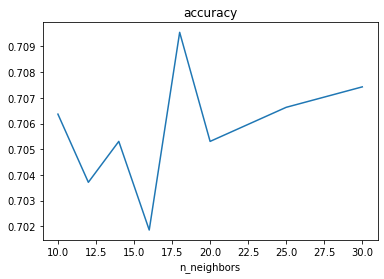

In [256]:
plt.plot(n_s, accs)
plt.xlabel('n_neighbors')
plt.title('accuracy')

plt.show();

In [257]:
print("max accuracy is {}".format(max(accs)))

max accuracy is 0.7095490716180372
